In [1]:
%matplotlib inline
from __future__ import division
import cvxpy as cvx
import matplotlib.pyplot as plt
import numpy as np

[4.0, 1.0] [1.0, 1.0]
x (40, 2) y (40,)Generated
[3.5, 4.0] [0.5, 4.0]
x (40, 2) y (40,)Generated
[4.0, 6.0] [0.7, 8.0]
x (40, 2) y (40,)Generated
[6.0, 6.0] [3.2, 9.0]
x (40, 2) y (40,)Generated
[8.0, 5.0] [6.0, 8.5]
x (40, 2) y (40,)Generated
[10.0, 5.0] [7.5, 2.0]
x (40, 2) y (40,)Generated
[10.5, 2.0] [10.0, 11.0]
x (40, 2) y (40,)Generated
[10.5, 8.0] [13.0, 2.0]
x (40, 2) y (40,)Generated
[12.0, 5.0] [13.0, 8.0]
x (40, 2) y (40,)Generated
[6.0, 4.0] [8.0, 8.0]
x (40, 2) y (40,)Generated
x (400, 2) y (400,)


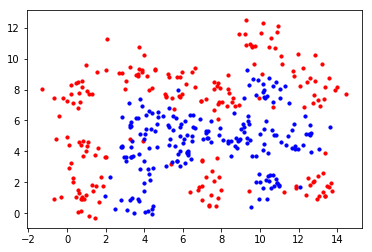

In [18]:
###Data Generation
DIM = 2
COLORS = ['red', 'blue']
np.random.seed(2)

fig, ax = plt.subplots()
def generate_gaussian(m, c, num):
    return np.random.multivariate_normal(m, c, num)
def plot_data_with_labels(ax, x, y):
    unique = np.unique(y)
    for li in range(len(unique)):
        x_sub = x[y == unique[li]]
        ax.scatter(x_sub[:, 0], x_sub[:, 1], c = COLORS[li], s=10)
def evaluate(y_hat, y_test):
    num_right = np.sum(y_hat==y_test)
    num_total = y_hat.shape[0]
    num_wrong = num_total - num_right
    top1accuracy = num_right/(num_total)
    top1error = num_wrong/num_total
    print "correct rate : ", num_right, "/", num_total
    print "top 1 accuracy", top1accuracy
    print "top 1 error", top1error

def generate_dataset_pair(M1,M2,C1,C2,NUM_total,NUM_test):
    x1 = generate_gaussian(M1, C1, NUM_total)
    y1 = np.ones((x1.shape[0],))
    x2 = generate_gaussian(M2, C2, NUM_total)
    y2 = -np.ones((x2.shape[0],))
    x_train = np.concatenate((x1[:-NUM_test,:], x2[:-NUM_test,:]), axis = 0)
    x_test = np.concatenate((x1[-NUM_test:,:], x2[-NUM_test:,:]), axis =0)
    y_train = np.concatenate((y1[:-NUM_test], y2[:-NUM_test]), axis = 0)
    y_test = np.concatenate((y1[-NUM_test:], y2[-NUM_test:]), axis = 0)
    print M1.tolist(), M2.tolist()
    print('x {} y {}'.format(x_train.shape, y_train.shape) + "Generated")
    train_set = (x_train, y_train)
    test_set = (x_test, y_test)
    return train_set, test_set

NUM = 20
NUM_test = int(NUM*0.2)
NUM_total = NUM + NUM_test

M1 = (4,1) * np.ones((DIM,))
M2 = np.ones((DIM,))
C1 = np.diag(0.7 * np.ones((DIM,)))
C2 = np.diag(0.4 * np.ones((DIM,)))

train_set, test_set = generate_dataset_pair(M1,M2,C1,C2,NUM_total,NUM_test)
x_train = train_set[0]
y_train = train_set[1]
x_test = test_set[0]
y_test = test_set[1]

def get_another_pair(new_cor_1, new_cor_2, x_train, y_train, x_test, y_test):
    M1 = new_cor_1 * np.ones((DIM,))
    M2 = new_cor_2 * np.ones((DIM,))
    C1 = np.diag(0.4 * np.ones((DIM,)))
    C2 = np.diag(0.7 * np.ones((DIM,)))
    train_set, test_set = generate_dataset_pair(M1,M2,C1,C2,NUM_total,NUM_test)
    x_train = np.concatenate((x_train,train_set[0]), axis=0)
    y_train = np.concatenate((y_train,train_set[1]), axis=0)
    x_test = np.concatenate((x_test,test_set[0]), axis=0)
    y_test = np.concatenate((y_test,test_set[1]), axis=0)
    return x_train, y_train, x_test, y_test

x_train, y_train, x_test, y_test = get_another_pair((3.5,4),(0.5,4),x_train, y_train, x_test, y_test)
x_train, y_train, x_test, y_test = get_another_pair((4,6),(0.7,8),x_train, y_train, x_test, y_test)
x_train, y_train, x_test, y_test = get_another_pair((6,6),(3.2,9),x_train, y_train, x_test, y_test)
x_train, y_train, x_test, y_test = get_another_pair((8,5),(6,8.5),x_train, y_train, x_test, y_test)
x_train, y_train, x_test, y_test = get_another_pair((10,5),(7.5,2),x_train, y_train, x_test, y_test)
x_train, y_train, x_test, y_test = get_another_pair((10.5,2),(10,11),x_train, y_train, x_test, y_test)
x_train, y_train, x_test, y_test = get_another_pair((10.5,8),(13,2),x_train, y_train, x_test, y_test)
x_train, y_train, x_test, y_test = get_another_pair((12,5),(13,8),x_train, y_train, x_test, y_test)
x_train, y_train, x_test, y_test = get_another_pair((6,4),(8,8),x_train, y_train, x_test, y_test)

print('x {} y {}'.format(x_train.shape, y_train.shape))
plot_data_with_labels(ax, x_train, y_train)
NUM_train = int(x_train.shape[0])
NUM_test = int(x_test.shape[0])
NUM_total = NUM_train + NUM_test

In [19]:
y_train.shape

(400,)

In [20]:
# Dual form
alpha = cvx.Variable(NUM_train)
C = cvx.Parameter(value=1)
# sigma = cvx.Parameter(value=0.1)
sigma = 0.1
# P = (np.diag(y_train) *(cvx.power(1 + np.dot(x_train,x_train.T) , 2))* np.diag(y_train))
rbf_temp = np.empty([NUM_train,NUM_train])
for i in range(NUM_train):
    for j in range(NUM_train):
        rbf_temp[i,j] = np.square(np.linalg.norm(x_train[i]-x_train[j]))
rbf_temp2 = -rbf_temp/np.square(sigma)
rbf_kernel = np.exp(rbf_temp2)
P = (np.diag(y_train) *(rbf_kernel)* np.diag(y_train))
loss = cvx.sum_entries(alpha)-0.5*cvx.quad_form(alpha, P)
const = []
for i  in range(NUM_train):
    const.append(0 <= alpha[i])
    const.append(alpha[i] <= C)
const.append(((alpha.T)*y_train)==0)
prob = cvx.Problem(cvx.Maximize(loss), const)
import time
start_time = time.time()
prob.solve(verbose=True)
# prob.solve(solver="CVXOPT",verbose=True)
end_time = time.time()
print end_time - start_time


ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  -2.000e+02  -8.757e+02  +2e+03  4e-01  9e-04  1e+00  2e+00    ---    ---    1  1  - |  -  - 
 1  -3.539e+02  -4.018e+02  +2e+02  2e-02  4e-05  6e-01  3e-01  0.9785  1e-01   1  1  2 |  0  0
 2  -3.706e+02  -4.034e+02  +2e+02  1e-02  3e-05  4e-01  2e-01  0.4379  3e-01   2  2  2 |  0  0
 3  -2.462e+02  -3.449e+02  +2e+02  9e-02  1e-05  2e+00  2e-01  0.1165  9e-01   3  3  3 |  0  0
 4  -2.972e+02  -3.029e+02  +9e+00  5e-03  5e-07  2e-01  1e-02  0.9462  2e-04   3  3  3 |  0  0
 5  -2.852e+02  -2.892e+02  +4e+00  5e-03  3e-07  1e-01  5e-03  0.9890  4e-01   3  3  3 |  0  0
 6  -2.484e+02  -2.518e+02  +1e+00  5e-03  3e-07  2e-01  2e-03  0.9167  3e-01   4  4  4 |  0  0
 7  -2.315e+02  -2.324e+02  +3e-01  1e-03  7e-08  3e-02  4e-04  0.9482  2e-01   4  3  2 |  0  0
 8  -2.125e+02  -2.130e+02  +1e-01  1e-03  4e-

In [5]:
_alpha = np.array(alpha.value)
y_ = np.expand_dims(y_train,1)

In [6]:
sum_val = np.empty([NUM_train,])
for j in range(NUM_train):
    temp_right = 0
    for i in range(NUM_train):
        temp_right += _alpha[i]*y_[i]*rbf_kernel[i,j]
    sum_val[j] = 1/y_[j] - temp_right
_beta_0 = sum_val.mean()

In [7]:
y_train_hat = np.empty([NUM_train,])
for j in range(NUM_train):
    sum_val2 = 0
    for i in range(NUM_train):
        sum_val2 += _alpha[i]*y_[i]*rbf_kernel[i,j]
    y_train_hat[j] = sum_val2/NUM_train

In [8]:
# y_train_hat_sign = np.sign(y_train_hat)
# (y_train_hat_sign == y_train).sum()

In [10]:
# x_ = np.arange(0, 5)
# slope = -_beta[0]/_beta[1]
# inter = -_beta_0/_beta[1]

In [11]:
# ax.plot(x_, x_ * slope + inter)
# fig

NameError: name 'slope' is not defined

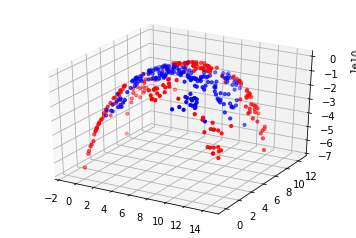

In [68]:
# fig2, ax2 = plt.subplots()
# plot_data_with_labels(ax2, x_test, y_test)
sigma = 1
pol_temp = np.empty([NUM_train,NUM_train])
for i in range(NUM_train):
    for j in range(NUM_train):
        pol_temp[i,j] = np.dot(x_train[i].T,x_train[j])
pol_temp2 = pol_temp/np.square(sigma)
pol_kernel = np.power((1 + rbf_temp2),3)
z_ = np.empty([NUM_train,])
for j in range(NUM_train):
    sum_val_i=0
    for i in range(NUM_train):
        sum_val_i += pol_kernel[i,j]
    z_[j] = sum_val_i
figt = plt.figure()
from mpl_toolkits.mplot3d import Axes3D
axt = figt.add_subplot(111, projection='3d')
unique = np.unique(y_train)
z_plot = np.expand_dims(z_,1)
for li in range(len(unique)):
    x_sub = x_train[y_train == unique[li]]
    x_sub_z = z_plot[y_train == unique[li]]
    axt.scatter(x_sub[:, 0], x_sub[:, 1], x_sub_z[:,0], zdir='z',c = COLORS[li], s=10)

In [ ]:
ax2.plot(x_, x_ * slope + inter)
fig2

In [ ]:
y_test_hat = np.empty([NUM_test,])
for j in range(NUM_test):
    sum_val3 = 0
    for i in range(NUM_train):
        sum_val3 += _alpha[i]*y_[i]*rbf_kernel[i,j]
    y_test_hat[j] = sum_val3/NUM_train + _beta_0

In [ ]:
evaluate(np.sign(y_test_hat),y_test)

In [ ]:
    
y_hat = np.dot(x_test,_beta) + _beta_0
y_hat = np.sign(y_hat.squeeze())
evaluate(y_hat,y_test)